<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_FFN_FFN_breadthVsDepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

In [ ]:
# shape of the data matrix
data.shape

(20000, 785)

In [ ]:
# extract labels (numbers IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


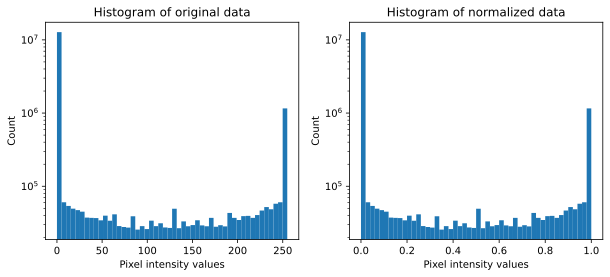

In [ ]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title("Histogram of original data")
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

## Create train/test groups using dataloader

In [ ]:
# step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

# step 2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)

# step 3: convert into pyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## Create the DL model

In [ ]:
# create a class for the model

def createTheMNISTNet(nLayers, nUnits):

    class mnistNet(nn.Module):
        def __init__(self, nLayers, nUnits):
            super().__init__()

            # create dictionary to store the layers
            self.layers = nn.ModuleDict()
            self.nLayers = nLayers


            ## input layer
            self.layers['input'] = nn.Linear(784, nUnits)
            

            ## hidden layer
            for i in range(nLayers):
                self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

            ## output layer
            self.layers['output'] = nn.Linear(nUnits, 10)
        
        # forward pass
        def forward(self, x):
            for hLayer in self.layers:
                x = F.relu(self.layers[hLayer](x))
            return x
        
    net = mnistNet(nLayers, nUnits)

    # loss function 
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

In [ ]:
# test the model with one batch
net, lossfun, optimizer = createTheMNISTNet(1, 64)

X, y = iter(train_loader).next()
yHat = net(X)
# value s are log-probability of each number (0-9)
print(yHat.shape)
# now let's compute the loss
loss = lossfun(yHat, y)
print(' ')
print('Loss: ')
print(loss)

torch.Size([32, 10])
 
Loss: 
tensor(2.3062, grad_fn=<NllLossBackward0>)


In [ ]:
net

mnistNet(
  (layers): ModuleDict(
    (input): Linear(in_features=784, out_features=64, bias=True)
    (hidden0): Linear(in_features=64, out_features=64, bias=True)
    (output): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
def function2trainTheModel(nLayers, nUnits):

    # number of epochs
    numepochs = 60

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet(nLayers, nUnits)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y 
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric) 
            batchAcc.append(accuracyPct) 

        # end of batch loop

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))
        yHat = net(X)

        # compare the following really lon gline of code the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    # end epochs
    
    # function output
    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [ ]:
trainAcc, testAcc, losses, net = function2trainTheModel(2, 64)

In [ ]:
len(trainAcc)

60

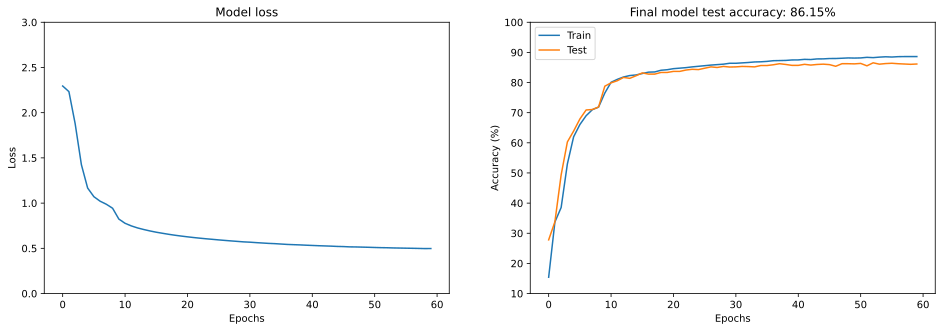

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].set_ylim([10, 100])
ax[1].legend()

plt.show()

In [ ]:
# Experiment times

In [ ]:
import numpy as np
hidden_layers = [1, 2, 3]
hidden_units = np.arange(50, 250, 20)
# hidden_units

trainResults = np.zeros((len(hidden_units), len(hidden_layers)))

testResults = np.zeros((len(hidden_units), len(hidden_layers)))

for i, nLayers in enumerate(hidden_layers):
    for j, nUnits in enumerate(hidden_units):
        print(f'layer {i} with {nUnits} unit')
        trainAcc, testAcc, losses, net = function2trainTheModel(nLayers, nUnits)
        trainResults[j, i] = np.mean(trainAcc[:10])
        testResults[j, i] = np.mean(testAcc[:10])






layer 0 with 50 unit
layer 0 with 70 unit
layer 0 with 90 unit
layer 0 with 110 unit
layer 0 with 130 unit
layer 0 with 150 unit
layer 0 with 170 unit
layer 0 with 190 unit
layer 0 with 210 unit
layer 0 with 230 unit
layer 1 with 50 unit
layer 1 with 70 unit
layer 1 with 90 unit
layer 1 with 110 unit
layer 1 with 130 unit
layer 1 with 150 unit
layer 1 with 170 unit
layer 1 with 190 unit
layer 1 with 210 unit
layer 1 with 230 unit
layer 2 with 50 unit
layer 2 with 70 unit
layer 2 with 90 unit
layer 2 with 110 unit
layer 2 with 130 unit
layer 2 with 150 unit
layer 2 with 170 unit
layer 2 with 190 unit
layer 2 with 210 unit
layer 2 with 230 unit


In [ ]:
net

mnistNet(
  (layers): ModuleDict(
    (input): Linear(in_features=784, out_features=230, bias=True)
    (hidden0): Linear(in_features=230, out_features=230, bias=True)
    (hidden1): Linear(in_features=230, out_features=230, bias=True)
    (hidden2): Linear(in_features=230, out_features=230, bias=True)
    (output): Linear(in_features=230, out_features=10, bias=True)
  )
)

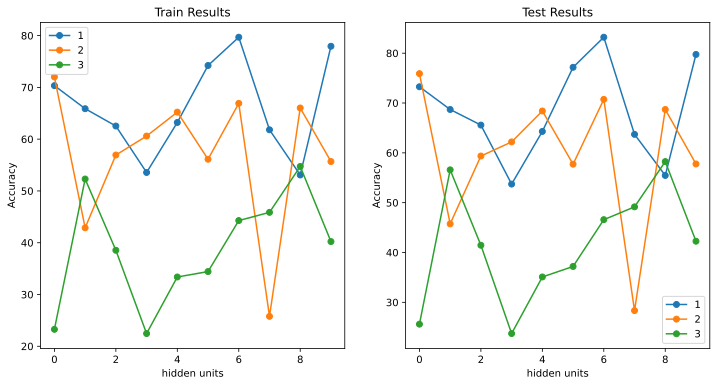

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(trainResults, 'o-')
ax[0].set_title('Train Results')
ax[0].set_xlabel('hidden units')
ax[0].set_ylabel('Accuracy')
# ax[0].set_xlim([50, 250])
ax[0].legend(hidden_layers)

ax[1].plot(testResults, 'o-')
ax[1].set_title('Test Results')
ax[1].set_xlabel('hidden units')
ax[1].set_ylabel('Accuracy')
# ax[1].set_xlim([50, 250])
ax[1].legend(hidden_layers)

plt.show()


## Inspect the results in more detail

In [ ]:
# run the model through for the test data
X, y = next(iter(test_loader))
predictions = net(X).detach()

In [ ]:
torch.exp(predictions)

In [ ]:
# Evidence for all numbers from one sample
sample2show = 323

plt.bar(range(10), torch.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('predictions')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

In [ ]:
# find the errors
errors = np.where(torch.max(predictions, axis=1)[1] != y)[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 4

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'%(y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item()))
ax[1].imshow(np.reshape(X[errors[sample2show], :], (28, 28)), cmap='gray')

plt.show()